In [1]:
# Import some basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')
# The following code is a modification of the code found here:
# https://stackoverflow.com/questions/35651932/plotting-img-with-matplotlib
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
def imscatter(x, y, images, cmap=plt.cm.gray_r, ax=None, zoom=1):
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0, image in zip(x, y, images):
        im = OffsetImage(image, zoom=zoom, cmap=cmap, interpolation='nearest')
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

# Hands-on Activity 18.3 - Density Estimation with High-dimensional Data

## Objectives

+ Combine principal component analysis with the Gaussian mixture model to solve high-dimensional density estimation problems

In this hands-on activity we are going to create a model that can sample hand-written digits.
To achieve this, we are going to use PCA to reduce the dimensionality of the MNIST images and then apply Gaussian mixture density estimation on the principal components.
The resulting model will not be perfect, but it very simple and a decent start.
For simplicity, we are going to work only with the threes.

Start by loading the data and extracting the threes:

In [39]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
threes = x_train[y_train == 3]
vectorized_threes = threes.reshape((threes.shape[0], threes.shape[1] * threes.shape[2]))

Apply PCA to the threes keeping just a few components:

In [40]:
from sklearn.decomposition import PCA
# How many PCA components you want to keep:
num_components = 2
pca = PCA(n_components=num_components, whiten=True).fit(vectorized_threes)

Now use the Gaussian mixture model on the principal components.
We are also going to use BIC to figure out what is the right number of mixture components.

In [41]:
from sklearn.mixture import GaussianMixture
# The principal components:
Z = pca.transform(vectorized_threes)
# Train with different number of mixture components and estimate BIC
bics = []
models = []
for nmc in range(1,10):
    m = GaussianMixture(n_components=nmc).fit(Z)
    bics.append(m.bic(Z))
    models.append(m)
bics = np.array(bics)

Here are the BICS:

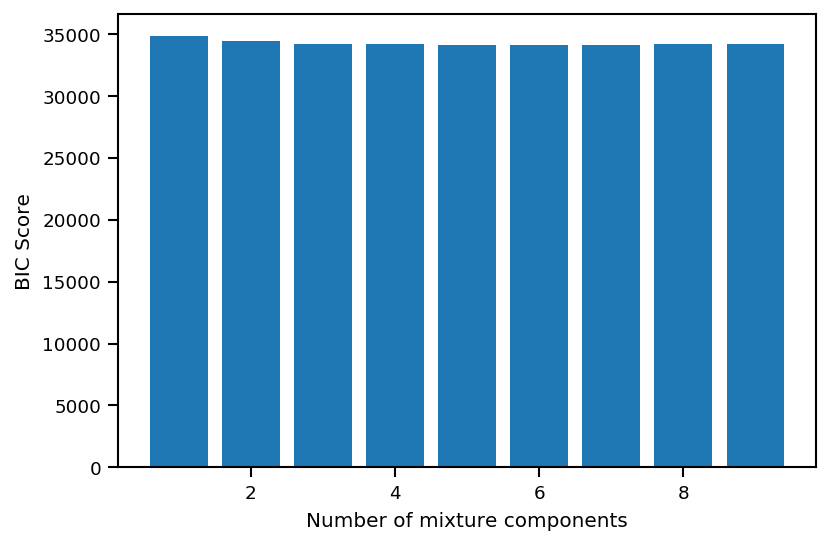

In [42]:
fig, ax = plt.subplots(dpi=150)
ax.bar(range(1, 10), bics)
ax.set_ylabel('BIC Score')
ax.set_xlabel('Number of mixture components');

Let's find the mixture model with the smallest BIC:

In [43]:
model = models[np.argmin(bics)]
print(model)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)


It's six components.

Now let's sample some random threes...

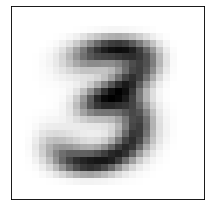

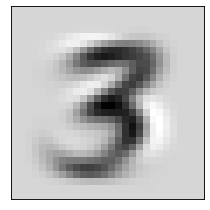

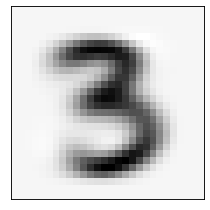

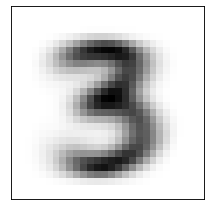

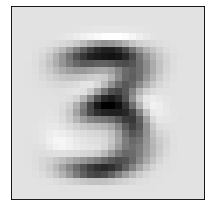

In [44]:
for i in range(5):
    z = model.sample()[0]
    x = pca.inverse_transform(z[None, :])
    fig, ax = plt.subplots(dpi=64)
    ax.imshow(x.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

### Question

+ Try the same code above with ones instead of threes. You just need to modify the code line ``threes = x_train[y_train == 3]`` to ``threes = x_train[y_train == 1]``. Don't bother about renaming the variables.

+ Try increasing the number of PCA components (3, 5, 10, 20). Do the results improve or become worse? What seems to be the problem?